# Step 1: Import Necessary Libraries

We start by importing the necessary libraries for our task.

In [2]:
# Import necessary libraries


import torch
import torch.nn as nn
from fastai.vision.models import resnet34, ResNet34_Weights
from fastai.vision.all import PILImage, tensor
import pandas as pd
import numpy as np
from google.colab import drive
from pathlib import Path
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.compose import ColumnTransformer
from sklearn.experimental import enable_hist_gradient_boosting
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.model_selection import RandomizedSearchCV
import matplotlib.pyplot as plt
import seaborn as sns

# Mount Google Drive
drive.mount('/content/drive')


/usr/local/lib/python3.10/dist-packages/sklearn/experimental/enable_hist_gradient_boosting.py:16: UserWarning: Since version 1.0, it is not needed to import enable_hist_gradient_boosting anymore. HistGradientBoostingClassifier and HistGradientBoostingRegressor are now stable and can be normally imported from sklearn.ensemble.
  warnings.warn(


Mounted at /content/drive


# Step 2: Mount Google Drive and Load Data

We mount Google Drive to access the dataset and load the data into a pandas DataFrame.

In [3]:
cars_data_directory = '/content/drive/My Drive/cars_dataset/'
cars_data_images = '/content/drive/My Drive/cars_photos/dataset_mono/images/'
cars_data_file = Path(cars_data_directory) / 'final_dataset.csv'
df = pd.read_csv(cars_data_file)
df['image_path'] = cars_data_images + df['filename']
df = df[['image_path', 'Mileage', 'Transmission', 'Engine', 'Fuel', 'price']]


# Step 3: Set Up Pre-trained Model

We load a pre-trained ResNet34 model, removing the final layer to use it for feature extraction.



In [4]:
model = resnet34(weights=ResNet34_Weights.IMAGENET1K_V1)
model = nn.Sequential(*list(model.children())[:-1])
model.eval()


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 123MB/s]


Sequential(
  (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (2): ReLU(inplace=True)
  (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (4): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Con

# Step 4: Feature Extraction Function

We define a function to extract features from car images using the pre-trained ResNet34 model.

In [5]:
def extract_features(img_path, model):
    img = PILImage.create(img_path)
    img = img.resize((224, 224))
    img_tensor = tensor(img).permute(2, 0, 1).unsqueeze(0).float()
    with torch.no_grad():
        features = model(img_tensor).squeeze().numpy()
        features_norm = (features - np.min(features)) / (np.max(features) - np.min(features))
    return features_norm

df['features'] = df['image_path'].apply(lambda x: extract_features(x, model))
features_df = pd.DataFrame(df['features'].tolist())
result_df = pd.concat([df, features_df], axis=1).drop(columns=['features'])

# Ensure all column names are strings
result_df.columns = result_df.columns.astype(str)


# Step 5: Preprocessing and Splitting Data

We preprocess the data by scaling numerical features and one-hot encoding categorical features. The data is then split into training and test sets.

In [6]:
categorical_features = ['Transmission', 'Fuel']
numerical_features = ['Mileage', 'Engine']

preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(), categorical_features),
    ])

X = result_df.drop(columns=['image_path', 'price'])
y = result_df['price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 6: Define Parameter Grid and Perform RandomizedSearchCV

We define a parameter grid and use RandomizedSearchCV to find the best parameters for the Gradient Boosting Regressor.

In [7]:
param_grid = {
    'regressor__n_estimators': [100, 200, 300],
    'regressor__max_depth': [3, 5, 7],
    'regressor__learning_rate': [0.01, 0.1, 0.2],
    'regressor__subsample': [0.8, 1.0]
}

reg_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                               ('regressor', GradientBoostingRegressor(random_state=42))])

grid_search = RandomizedSearchCV(reg_pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', n_iter=50, n_jobs=-1, random_state=42)
grid_search.fit(X_train, y_train)


RandomizedSearchCV(cv=5,
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(transformers=[('num',
                                                                               StandardScaler(),
                                                                               ['Mileage',
                                                                                'Engine']),
                                                                              ('cat',
                                                                               OneHotEncoder(),
                                                                               ['Transmission',
                                                                                'Fuel'])])),
                                             ('regressor',
                                              GradientBoostingRegressor(random_state=42))]),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'regressor__learning_rate': [0.01, 0.1,
                                                                     0.2],
                                        'regressor__max_depth': [3, 5, 7],
                                        'regressor__n_estimators': [100, 200,
                                                                    300],
                                        'regressor__subsample': [0.8, 1.0]},
                   random_state=42, scoring='neg_mean_squared_error')

# Step 7: Model Evaluation and Plotting Results

We evaluate the model using the test set and plot the actual vs. predicted prices as well as the density plots of predicted and actual prices.

Root Mean Squared Error: 15.093479650859937


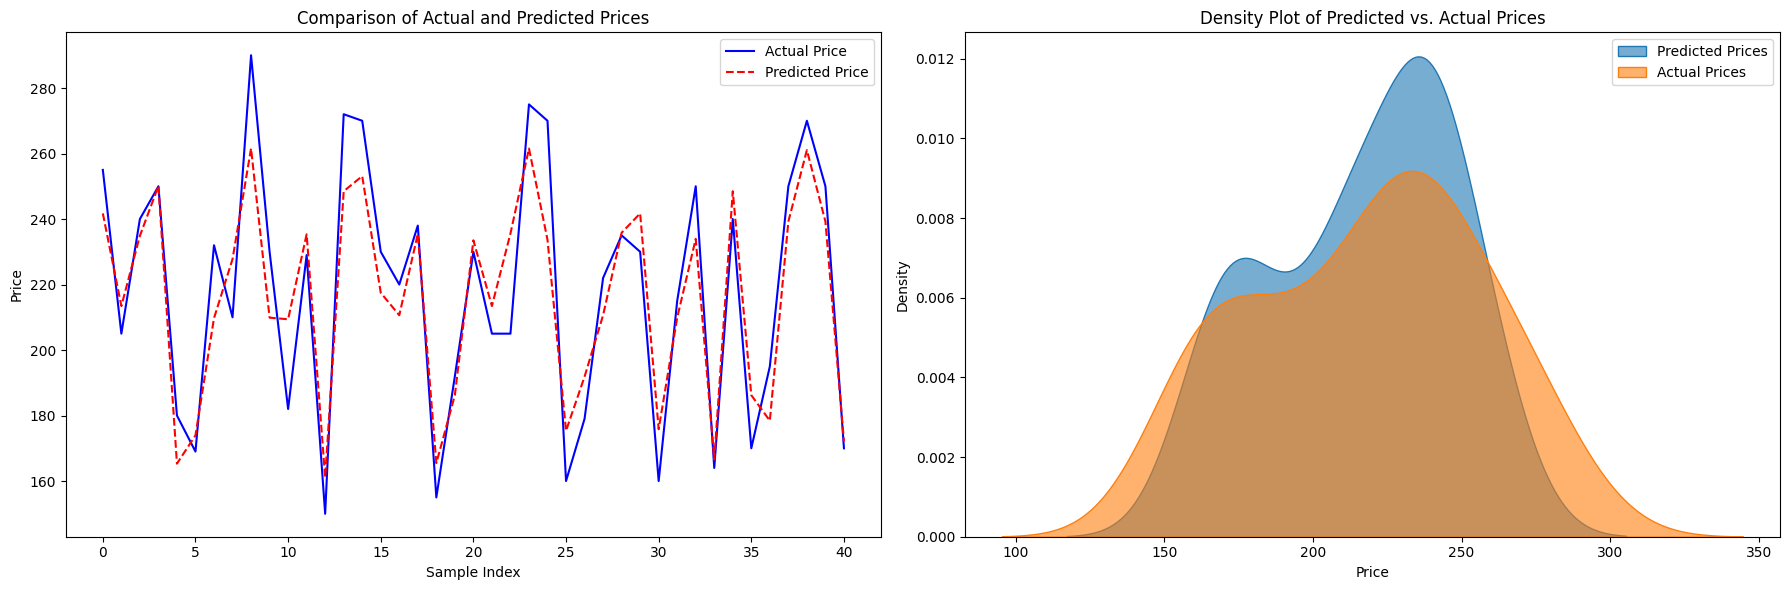

In [8]:
y_pred = grid_search.predict(X_test)
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse}")

fig, axs = plt.subplots(1, 2, figsize=(18, 6))

# Plot for Comparison of Actual and Predicted Prices
axs[0].plot(y_test.reset_index(drop=True), label='Actual Price', color='blue')
axs[0].plot(y_pred, label='Predicted Price', linestyle='--', color='red')
axs[0].set_title('Comparison of Actual and Predicted Prices')
axs[0].set_xlabel('Sample Index')
axs[0].set_ylabel('Price')
axs[0].legend()

# Plot for Density Plot of Predicted vs. Actual Prices
sns.kdeplot(y_pred, fill=True, label='Predicted Prices', alpha=0.6, ax=axs[1])
sns.kdeplot(y_test, fill=True, label='Actual Prices', alpha=0.6, ax=axs[1])
axs[1].set_title('Density Plot of Predicted vs. Actual Prices')
axs[1].set_xlabel('Price')
axs[1].legend()

plt.tight_layout()
plt.show()


# Step 8: Save the Model to Google Drive

First, we need to import joblib, and then we can save the grid_search object (which contains the trained model) to the specified path.

In [9]:
import joblib

# Define the path to save the model
model_save_path = '/content/drive/My Drive/Radnom_Forest_with_resnet.pkl'

# Save the trained model pipeline
joblib.dump(grid_search, model_save_path)

print(f"Model saved to {model_save_path}")

Model saved to /content/drive/My Drive/Radnom_Forest_with_resnet.pkl
